In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import Aer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
#import the noise packages
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error,amplitude_damping_error,phase_damping_error,phase_amplitude_damping_error
from qiskit.providers.aer.noise import thermal_relaxation_error
seed = 12345
algorithm_globals.random_seed = seed

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def get_noise(p_bit,p_phase,p_gate1,p_gate2):
    bit_flip = pauli_error([('X',p_bit), ('I', 1 - p_bit)])#bit flip
    phase_flip = pauli_error([('Z', p_phase), ('I', 1 - p_phase)])#phase flip
    #bitphase_flip = phase_flip.compose(phase_flip)
    #error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2=amplitude_damping_error(p_gate1, excited_state_population=0, canonical_kraus=True)
    #error_gate3=phase_damping_error(p_gate, canonical_kraus=True)
    error_gate4=phase_amplitude_damping_error(p_gate1, p_gate2, excited_state_population=0, canonical_kraus=True)
    
    noise_model = NoiseModel()
    #noise_model.add_all_qubit_quantum_error(bit_flip, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate2, ["x","h"]) # single qubit gate error is applied to x gates
        
    return noise_model


In [4]:
#Give the proper parameter
noise_model = get_noise(0.1,0.1,0.1,0.1)  

In [5]:
from sklearn import datasets

iris = datasets.load_iris()
x = iris.data
y = iris.target

train_features = np.concatenate((x[:40], x[50:90]))
test_features = np.concatenate((x[40:50], x[90:100]))
train_labels = np.concatenate((np.zeros(40), np.ones(40)))
test_labels = np.concatenate((np.zeros(10), np.ones(10)))

In [6]:
iris_dimension = 4

feature_map = ZZFeatureMap(feature_dimension=iris_dimension, reps=2, entanglement="linear")

backend = QuantumInstance(
    Aer.get_backend("aer_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed, noise_model=noise_model)

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

In [7]:
print(feature_map)

     ┌────────────────────────────────────┐
q_0: ┤0                                   ├
     │                                    │
q_1: ┤1                                   ├
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │
q_2: ┤2                                   ├
     │                                    │
q_3: ┤3                                   ├
     └────────────────────────────────────┘


In [46]:
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.9


In [47]:
# evaluate data points
y_predict = qsvc.predict(test_features)

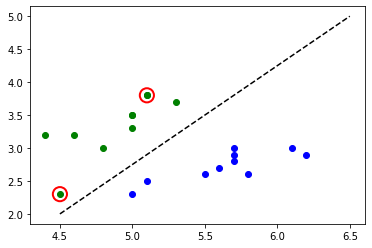

In [48]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(test_features, test_labels, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([4.5, 6.5], [2, 5], "--", color="black")
plt.show()

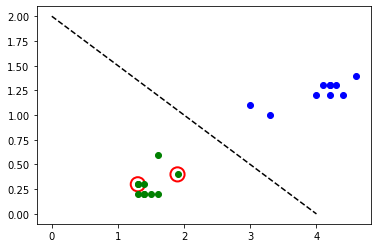

In [49]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(test_features, test_labels, y_predict):
    if y_target == 1:
        plt.plot(x[2], x[3], "bo")
    else:
        plt.plot(x[2], x[3], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[2], x[3], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([0, 4], [2, 0], "--", color="black")
plt.show()